### Load Data & Libs

In [1]:
from _py.config import config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import probplot

In [35]:
train = pd.read_sql('SELECT*FROM train', config.engine, index_col='id')
test = pd.read_sql('SELECT*FROM test', config.engine, index_col='id')

target = train[config.target_name]
train = train.drop(config.target_name, axis=1)

# EDA

In [3]:
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")
print(f"Null-sum | train: {train.isna().sum().sum()}, test: {test.isna().sum().sum()}")

train shape: (700000, 24)
test shape: (300000, 24)
Null-sum | train: 0, test: 0


In [4]:
base_all_features = train.columns.to_list()
base_cat_features = train.select_dtypes(include=['object', 'bool', 'category']).columns.to_list()
base_num_features = train.select_dtypes(include='number').columns.to_list()

## Target

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_piebar(data, columns=None, figsize=None, fontsize=10, palette='cividis'):
    """
    data: pd.Series or pd.DataFrame (if DataFrame, pass columns list)
    """
    df = data.copy()
    if isinstance(df, pd.Series):
        nrows = 1
        if df.name is None:
            df.name = 'Untitled'
        df = pd.DataFrame(df)
        columns = df.columns.to_list()
    elif isinstance(df, pd.DataFrame):
        if columns is not None:
            nrows = len(columns)
        else:
            raise ValueError('if data is DataFrame param columns should be provided')
    else:
        raise ValueError('data should be DataFrame with columns param or Series')
        
    figsize = (16, 5*nrows) if figsize is None else figsize
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=figsize,
                             gridspec_kw={'hspace': 0.5, 
                                          'wspace': 0.01, 
                                          'width_ratios': [0.4, 0.6]})
    axes = np.atleast_2d(axes)
    for i, col in enumerate(columns):
        vc = df[col].value_counts()       
        order = vc.index.tolist()            

        colors_list = sns.color_palette(palette, n_colors=len(order))
        palette_dict = {cat: colors_list[idx] for idx, cat in enumerate(order)}

        # pie-plot
        ax = axes[i, 0]
        ax.pie(
            vc.values,
            labels=order,
            colors=[palette_dict[c] for c in order],  # exact mapping
            autopct='%1.2f%%',
            textprops={'fontsize': fontsize}
        )
        ax.set_title(col, size=10)

        # bar-plot
        ax = axes[i, 1]
        sns.countplot(
            data=df,
            x=col,
            order=order,
            hue=col,
            palette=palette_dict,
            legend=False,
            ax=ax
        )

        ax.set_title(col, size=10)
        ax.set_xlabel('')
        # add labels on top of bars (handles single bars since hue == x)
        for container in ax.containers:
            ax.bar_label(container)
        ax.grid(alpha=0.25)

    plt.show()


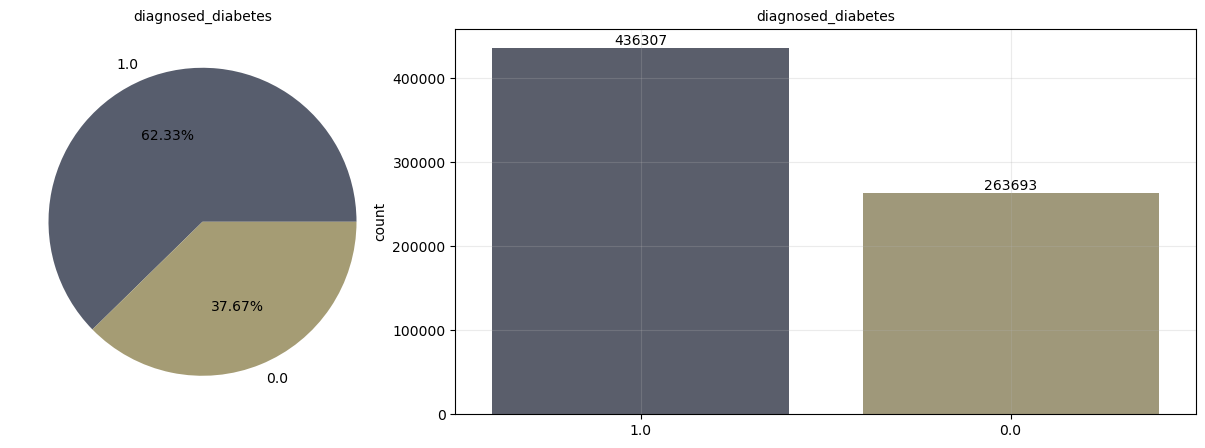

In [25]:
plot_piebar(target)

## Numerical Features

### Distribution

In [7]:
def plot_numeric(data, num_features=None, bins='auto', palette='cividis', figsize=None):
    data_ = pd.DataFrame(data.copy())
    num_features = data_.select_dtypes(include='number').columns.to_list() if num_features is None else list(np.array([num_features]))
    figsize = (25, len(num_features)*7) if figsize is None else figsize
    fig, axes = plt.subplots(nrows=len(num_features), ncols=3,
                             figsize=figsize,
                             gridspec_kw={'hspace': 0.5, 
                                          'wspace': 0.15, 
                                          'width_ratios': [0.5, 0.25, 0.25]})
    axes = np.atleast_2d(axes)
    for i, col in enumerate(num_features):
        # QQ-plot
        ax = axes[i, 2]
        probplot(data_[col], plot=ax)
        ax.get_lines()[0].set_color(sns.color_palette(palette)[1])
        ax.get_lines()[1].set_color('red')
        ax.set_title(col, size=13)
        
        # hist-plot
        ax = axes[i, 0]
        sns.histplot(data=data_, x=col, kde=True, ax=ax, bins=bins,
                     color=sns.color_palette(palette)[1], alpha=0.75)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(col, size=13)
        ax.set_axisbelow(True)
        ax.grid(True, alpha=0.5)
        ax.get_lines()[0].set_color('red')
        
        # box-plot
        ax = axes[i, 1]
        sns.boxplot(data=data_, y=col, ax=ax, color=sns.color_palette(palette)[1], width=0.33, linewidth=1, fliersize=3,
                    flierprops={"marker": "o"}, native_scale=True)

        ax.set_title(col, size=13)
        ax.set(xlabel = '', ylabel = '')
        ax.grid(True, alpha=0.5)
    plt.show()

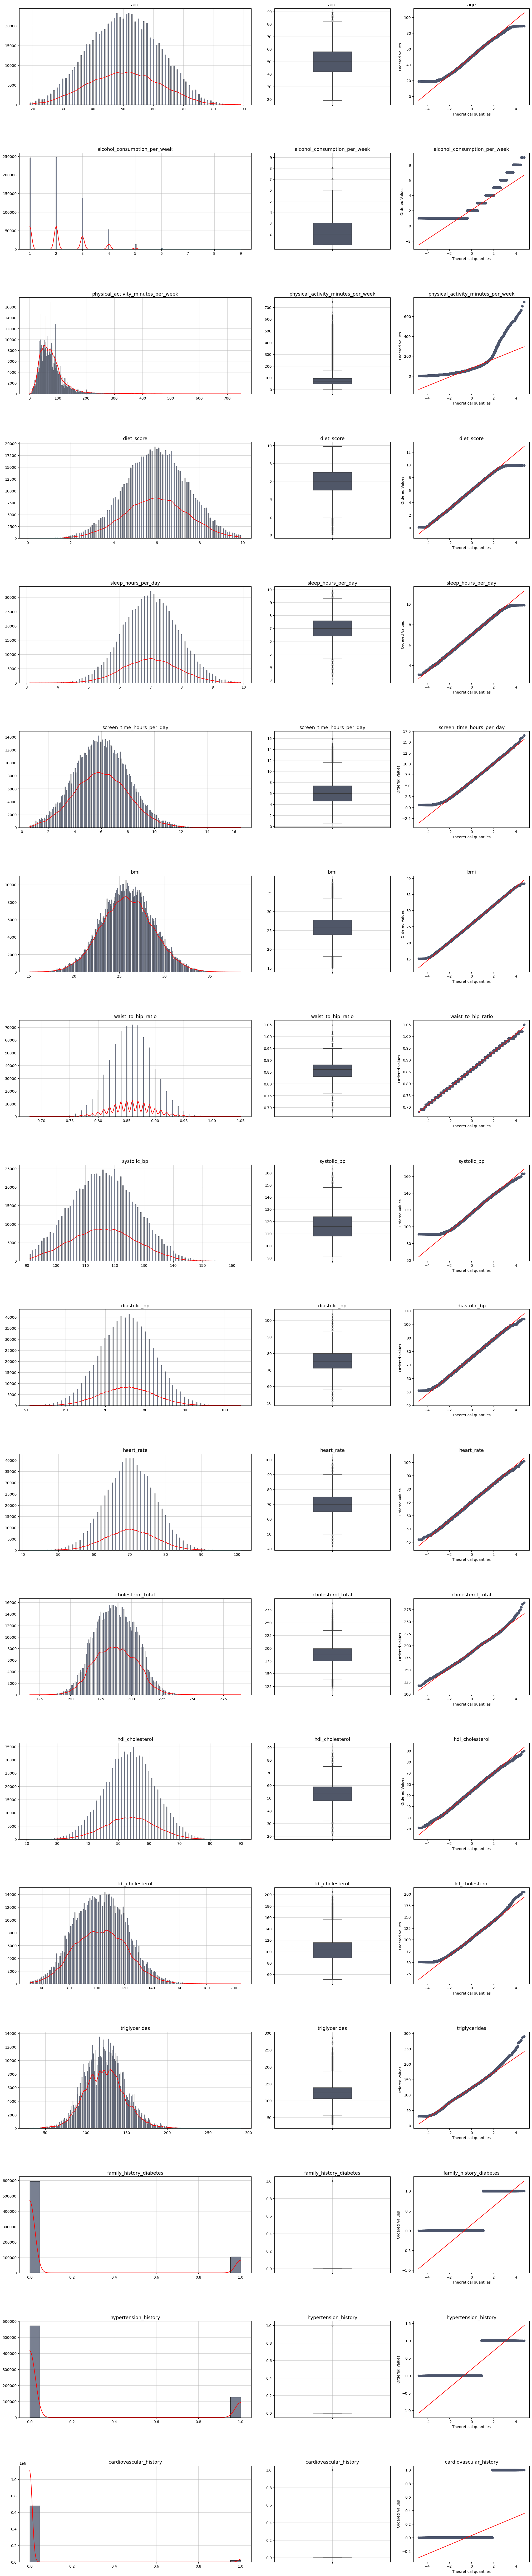

In [8]:
plot_numeric(train, bins='auto')

### !Не все числовые признаки - числовые

In [9]:
# plot_piebar(train, ['family_history_diabetes','hypertension_history','cardiovascular_history'])

## Heatmap

In [6]:
def plot_heatmap(data, target=None, method='pearson', figsize=(10, 8), cmap='cividis'):
    """
    """
    data_ = pd.DataFrame(data.copy())
    
    if target is not None:
        data_[target.name] = target
    num_features = data_.select_dtypes(exclude='object').columns.to_list()    
    fig, ax = plt.subplots(figsize=figsize)
    
    corr = data_[num_features].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    np.fill_diagonal(mask, False)
    
    cmap = sns.color_palette('cividis', len(num_features))[::-1]
    sns.heatmap(data=corr, mask=mask, fmt='0.2f', cmap=cmap, annot=True, alpha=1, square=True,
               center=0, vmin=-1, linewidths=0.55)
    plt.show()

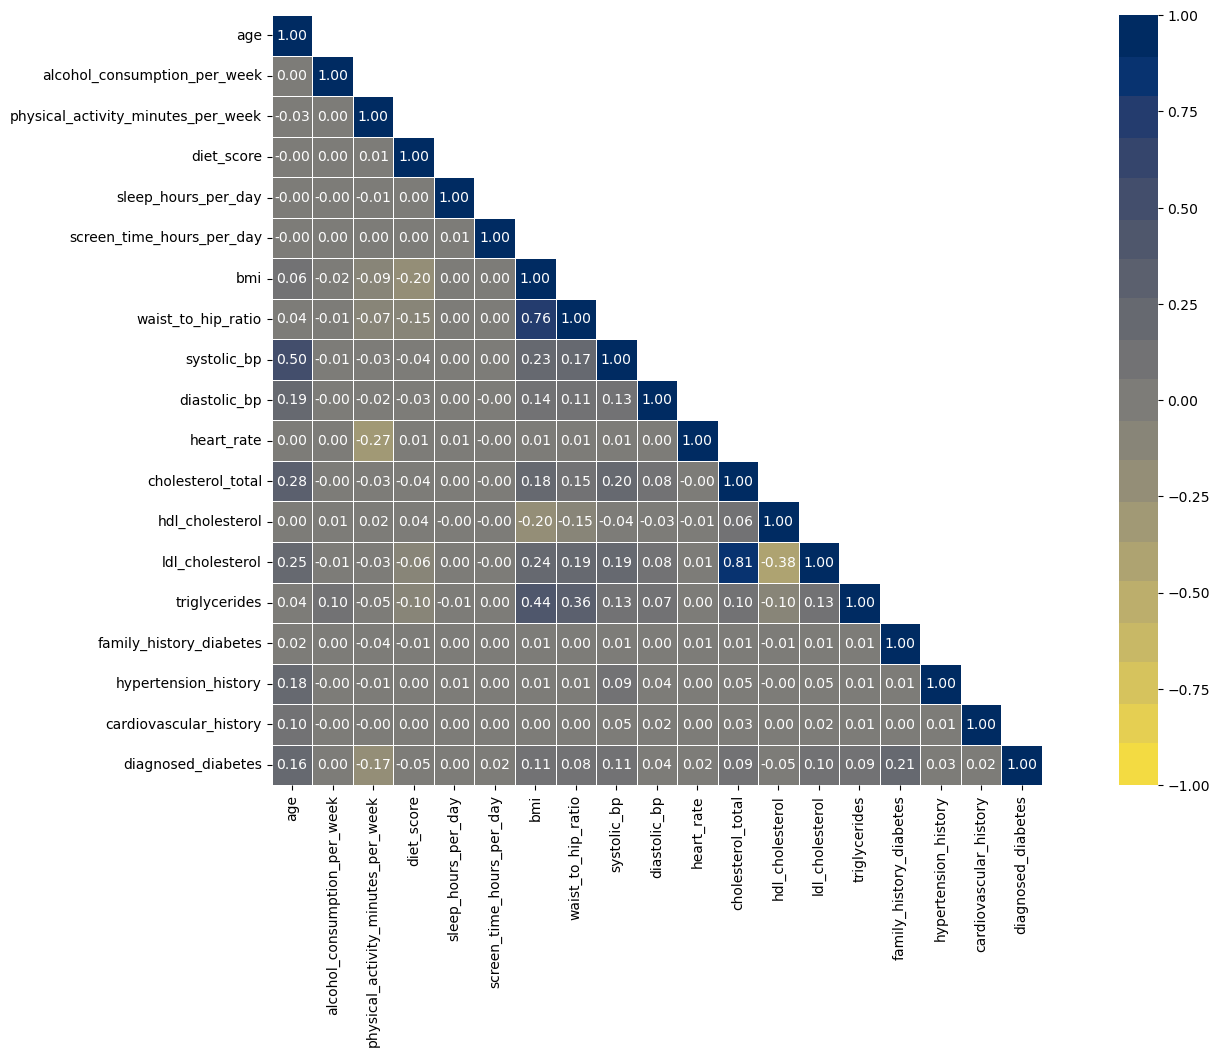

In [11]:
plot_heatmap(train, target, figsize=(20, 10))

## Categorical Featurs

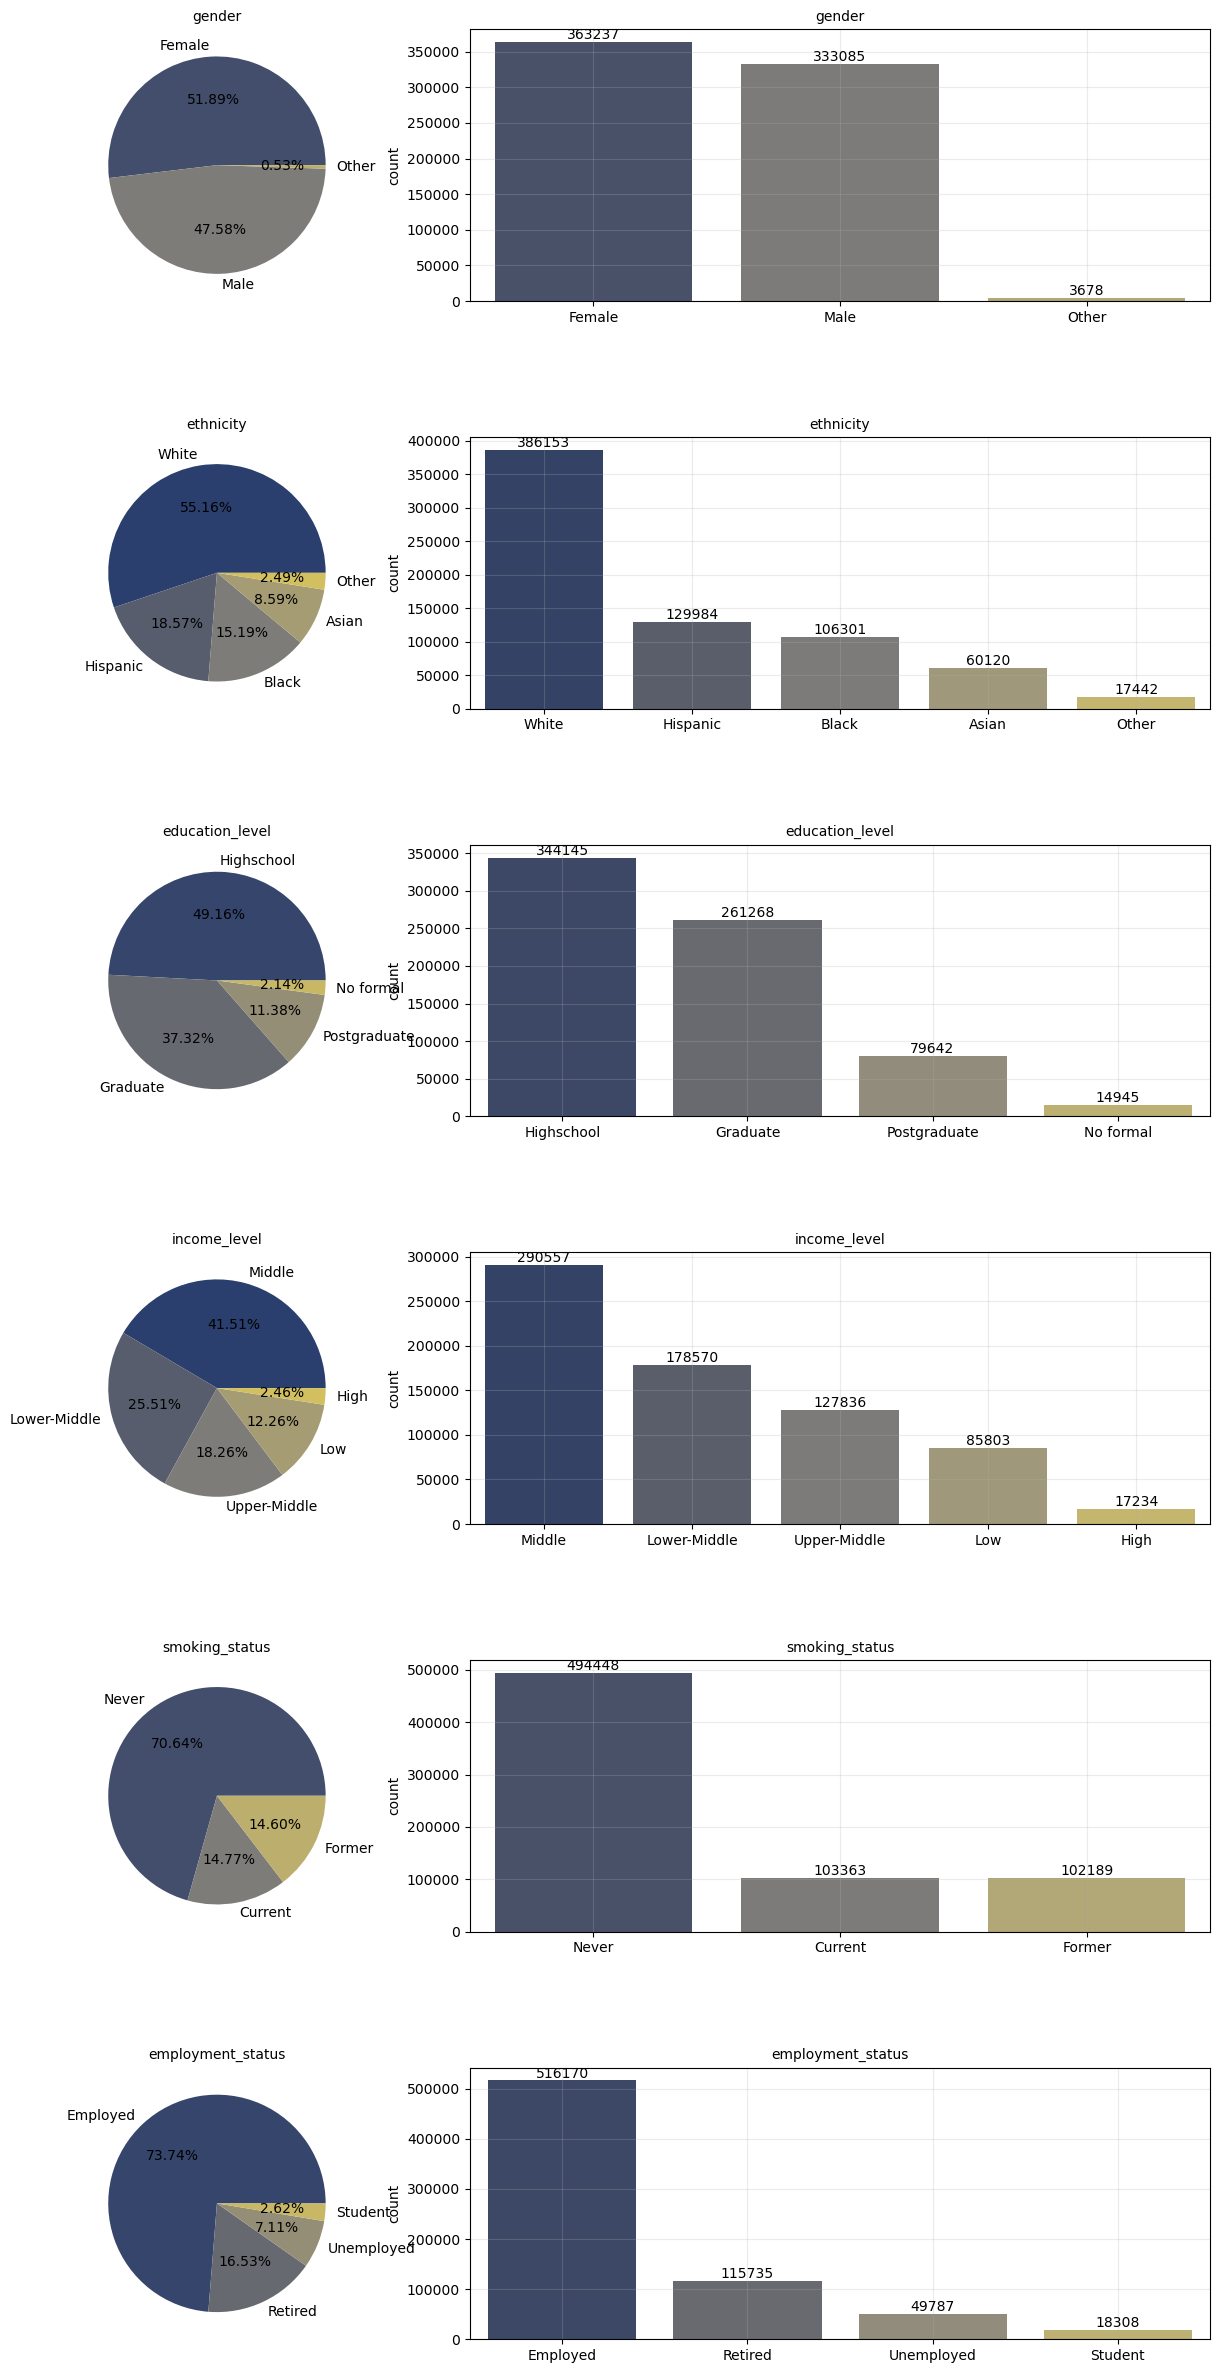

In [26]:
plot_piebar(train, cat_features)

# Representative

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=len(test), random_state=1, shuffle=True, stratify=target)


In [7]:
from scipy.stats import chisquare

class RepresentativeTester():
    def __init__(self, df_1, df_2):
        self.df_1 = pd.DataFrame(df_1.copy())
        self.df_2 = pd.DataFrame(df_2.copy())
        self.check_columns()
        self.res_tab = pd.DataFrame()

    def check_columns(self):
        if self.df_1.columns.to_list() != self.df_2.columns.to_list():
            raise ValueError('Колонки в датафреймах не совпадают')
        else:
            df_1_cat = self.df_1.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()
            df_2_cat = self.df_2.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()
            if df_1_cat != df_2_cat:
                raise ValueError('Категориальные признаки не совпадают')
            df_1_num = self.df_1.select_dtypes(include='number').columns.to_list()
            df_2_num = self.df_2.select_dtypes(include='number').columns.to_list()
            if df_1_num != df_2_num:
                raise ValueError('Числовые признаки не совпадают')
        self.cat_cols, self.num_cols = df_2_cat, df_2_num 
        
    def check_categorical_missing(self):
        missing_res = {}
        self.missing_res = {}
        for col in self.cat_cols:
            self.missing_res[col] = list(np.setdiff1d(self.df_1[col].unique(), self.df_2[col].unique())) # Разность множеств
            missing_res[col] = sorted(self.df_1[col].unique())==sorted(self.df_2[col].unique())
        self.res_tab['cat_missing'] = missing_res
        return self.missing_res
        # np.alltrue(rp.res_tab['cat_missing'])
    
    def check_chi(self):
        results_chi = {}
        for col in self.cat_cols:
            full_counts = self.df_2[col].value_counts().sort_index()
            sample_counts = self.df_1[col].value_counts().reindex(full_counts.index, fill_value=0)
            stat, p = chisquare(sample_counts, f_exp=full_counts * len(self.df_1)/len(self.df_2))
            results_chi[col] = {'stat': stat, 'p': p, 'Репрезентативен по категориям': p>=0.05}
        return pd.DataFrame(results_chi).T

In [10]:
rp = RepresentativeTester(train, test)
rp.check_categorical_missing()

{'gender': [],
 'ethnicity': [],
 'education_level': [],
 'income_level': [],
 'smoking_status': [],
 'employment_status': []}

# Preprocessing

In [196]:
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, codes=False):
        self.codes = codes

    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_out = X.copy()
        cat_cols = X_out.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()
        for col in cat_cols:
            if self.codes:
                X_out[col] = X_out[col].astype('category').cat.codes
            else:
                 X_out[col] = X_out[col].astype('category')
                
        return X_out

# Naive Ensemble

In [41]:
from sklearn.preprocessing import OrdinalEncoder

In [179]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

import catboost as cb
import xgboost as xgb
import lightgbm as lgbm

In [226]:
params_catboost = {
    "task_type": "GPU",
    "loss_function": "Logloss",
    "iterations": 500,
    "verbose": False,
}

def train_catboost(params, train_data, valid_data, cat_features, cat_kwargs=None):
    cat_kwargs = cat_kwargs or {}
    
    X_train, y_train = train_data
    X_valid, y_valid = valid_data
    pool = cb.Pool(X_train, y_train, cat_features=cat_features)

    model = cb.CatBoostClassifier(**params)
    model.fit(pool)
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)

    return model, y_pred_proba, y_pred

In [232]:
params_xgboost = {
    'device': 'gpu',
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'tree_method': 'hist'
}

def train_xgboost(params, train_data, valid_data, enable_categorical=True, num_boost_round=500, xgb_kwargs=None):
    xgb_kwargs = xgb_kwargs or {}
    
    X_train, y_train = train_data
    X_valid, y_valid = valid_data
    dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=enable_categorical)
    dvalid = xgb.DMatrix(X_valid, y_valid, enable_categorical=enable_categorical)
    
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round, **xgb_kwargs)
    y_pred_proba = model.predict(dvalid)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    return model, y_pred_proba, y_pred

In [231]:
params_lightgbm = {
    "device": "gpu",
    "objective": "binary",
    "boosting_type": "gbdt",
    'learning_rate': 0.1,
    "verbosity": -1,
}
def train_lightgbm(params, train_data, valid_data, cat_features, num_boost_round=500, lgbm_kwargs=None):
    lgbm_kwargs = lgbm_kwargs or {}
    
    X_train, y_train = train_data
    X_valid, y_valid = valid_data
    train_dataset = lgbm.Dataset(X_train, y_train, categorical_feature=cat_features)
    
    model = lgbm.train(params, train_dataset, num_boost_round=num_boost_round, **lgbm_kwargs)
    
    y_pred_proba = model.predict(X_valid)
    y_pred = (y_pred_proba > 0.5).astype(int)

    return model, y_pred_proba, y_pred

In [197]:
pr = Preprocessor()
X_train_prep = pr.fit_transform(X_train)
X_valid_prep = pr.transform(X_valid)

train_lightgbm(params_lightgbm, [X_train_prep, y_train], [X_valid_prep, y_valid], base_cat_features)

(<lightgbm.basic.Booster at 0x1af45b6d220>,
 array([0.79422359, 0.3600779 , 0.47377158, ..., 0.66655271, 0.34436687,
        0.93149201]),
 array([1, 0, 0, ..., 1, 0, 1]))

In [198]:
train_xgboost(params_xgboost, [X_train_prep, y_train], [X_valid_prep, y_valid])

(<xgboost.core.Booster at 0x1af9e53d5b0>,
 array([0.8323496 , 0.4614037 , 0.6452272 , ..., 0.65664893, 0.57417846,
        0.93852264], dtype=float32),
 array([1, 0, 1, ..., 1, 1, 1]))

## CatBoost

In [170]:
def train_ensemble(X, y, cat_features, verbose=True):
    all_features = X.columns.to_list()
    importances = []
    
    oof_pred_proba = np.zeros(X.shape[0], dtype=float)
    oof_pred = np.zeros(X.shape[0], dtype=int)

    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    for n_fold, (train_id, valid_id) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_id].copy()
        y_train = y.iloc[train_id]
        
        X_valid = X.iloc[valid_id].copy()
        y_valid = y.iloc[valid_id]

        model, y_pred_proba, y_pred  = train_catboost(catboost_params, [X_train, y_train], [X_valid, y_valid], cat_features=cat_features)
        oof_pred_proba[valid_id] = y_pred_proba
        oof_pred[valid_id] = y_pred

        # importances
        imp_ser = pd.Series( dict( zip(all_features, model.feature_importances_) ), name=f'cat_importance_{n_fold}')
        imp_ser = (imp_ser / np.sum(imp_ser)*100)
        importances.append(imp_ser)
        # verbose
        if verbose:
            acc_fold = accuracy_score(y_valid, y_pred)
            auc_fold = roc_auc_score(y_valid, y_pred_proba)
            print(f'CatBoost Model fold_{n_fold} | auc: {auc_fold:.4f} | accuracy: {acc_fold:.4f} ')

    acc = accuracy_score(y, oof_pred)
    auc = roc_auc_score(y, oof_pred_proba)
    
    print(f'CatBoost Model OOF | auc: {auc:.4f} | accuracy: {acc:.4f} ')
    # importances 
    imp_df = pd.DataFrame(importances).T
    imp_t = pd.Series(imp_df.mean(axis=1).round(2).sort_values(ascending=False).to_dict())
    
    return oof_pred_proba, imp_t

In [171]:
cat_oof, imp_t = train_ensemble(train, target, base_cat_features)

CatBoost Model fold_0 | auc: 0.7225 | accuracy: 0.6802 
CatBoost Model fold_1 | auc: 0.7197 | accuracy: 0.6780 
CatBoost Model fold_2 | auc: 0.7231 | accuracy: 0.6807 
CatBoost Model fold_3 | auc: 0.7189 | accuracy: 0.6786 
CatBoost Model fold_4 | auc: 0.7199 | accuracy: 0.6788 
CatBoost Model fold_5 | auc: 0.7216 | accuracy: 0.6798 
CatBoost Model fold_6 | auc: 0.7207 | accuracy: 0.6812 
CatBoost Model fold_7 | auc: 0.7203 | accuracy: 0.6817 
CatBoost Model fold_8 | auc: 0.7202 | accuracy: 0.6784 
CatBoost Model fold_9 | auc: 0.7241 | accuracy: 0.6808 
CatBoost Model OOF | auc: 0.7211 | accuracy: 0.6798 


In [262]:
def plot_importance(importances, figsize=(7, 5.5)):
    imp_t = pd.Series(importances)
    
    n_colors = len(imp_t.value_counts())
    plt.figure(figsize=figsize)
    ax = sns.barplot(imp_t.to_dict(), y=imp_t.index, x=imp_t, width=0.5,
            hue=imp_t, palette=sns.color_palette('summer', n_colors=n_colors)[::-1],  alpha=0.9, legend=False)

    for container in ax.containers:
        ax.bar_label(container)
        
    plt.grid(alpha=0.5)
    plt.title('Feature Importance')
    plt.xlabel('features')
    plt.ylabel('importance score')
    plt.show()

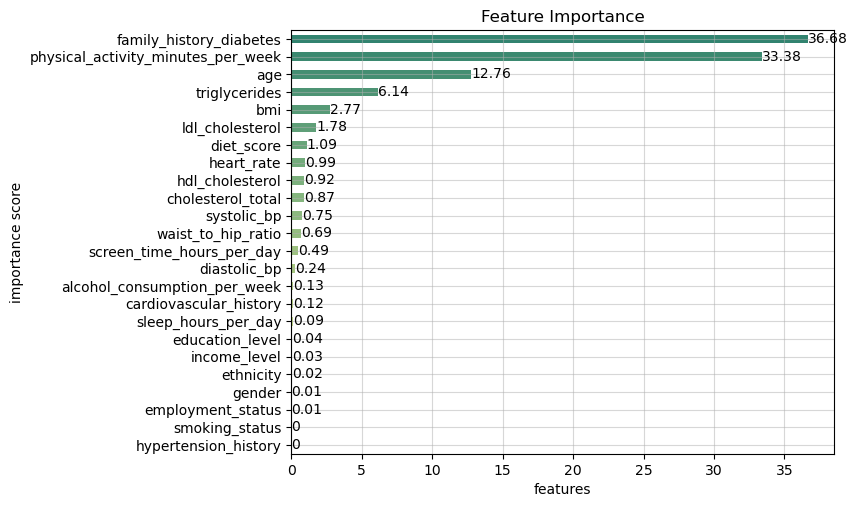

In [263]:
plot_importance(imp_t)

## XGBoost

In [235]:
def train_ensemble_2(X, y, cat_features, verbose=True):
    all_features = X.columns.to_list()
    importances = []
    
    oof_pred_proba = np.zeros(X.shape[0], dtype=float)
    oof_pred = np.zeros(X.shape[0], dtype=int)

    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    for n_fold, (train_id, valid_id) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_id].copy()
        y_train = y.iloc[train_id]
        
        X_valid = X.iloc[valid_id].copy()
        y_valid = y.iloc[valid_id]
        
        pr = Preprocessor()
        X_train = pr.fit_transform(X_train)
        X_valid = pr.transform(X_valid)
        
        model, y_pred_proba, y_pred  = train_xgboost(params_xgboost, [X_train, y_train], [X_valid, y_valid], num_boost_round=500)
        oof_pred_proba[valid_id] = y_pred_proba
        oof_pred[valid_id] = y_pred

        # importances
        imp_ser = pd.Series( model.get_score(), name=f'xgb_importance_{n_fold}' )
        imp_ser = (imp_ser / np.sum(imp_ser)*100)
        importances.append(imp_ser)
        # verbose
        if verbose:
            acc_fold = accuracy_score(y_valid, y_pred)
            auc_fold = roc_auc_score(y_valid, y_pred_proba)
            print(f'XGBoost Model fold_{n_fold} | auc: {auc_fold:.4f} | accuracy: {acc_fold:.4f} ')

    acc = accuracy_score(y, oof_pred)
    auc = roc_auc_score(y, oof_pred_proba)
    
    print(f'XGBoost Model OOF | auc: {auc:.4f} | accuracy: {acc:.4f} ')
    # importances 
    imp_df = pd.DataFrame(importances).T
    imp_t = pd.Series(imp_df.mean(axis=1).round(2).sort_values(ascending=False).to_dict())
    
    return oof_pred_proba, imp_t

In [236]:
xgb_oof, imp_t_2 = train_ensemble_2(train, target, base_cat_features)

XGBoost Model fold_0 | auc: 0.7266 | accuracy: 0.6840 
XGBoost Model fold_1 | auc: 0.7249 | accuracy: 0.6814 
XGBoost Model fold_2 | auc: 0.7272 | accuracy: 0.6847 
XGBoost Model fold_3 | auc: 0.7232 | accuracy: 0.6833 
XGBoost Model fold_4 | auc: 0.7236 | accuracy: 0.6833 
XGBoost Model fold_5 | auc: 0.7262 | accuracy: 0.6837 
XGBoost Model fold_6 | auc: 0.7254 | accuracy: 0.6845 
XGBoost Model fold_7 | auc: 0.7244 | accuracy: 0.6852 
XGBoost Model fold_8 | auc: 0.7249 | accuracy: 0.6826 
XGBoost Model fold_9 | auc: 0.7285 | accuracy: 0.6837 
XGBoost Model OOF | auc: 0.7255 | accuracy: 0.6836 


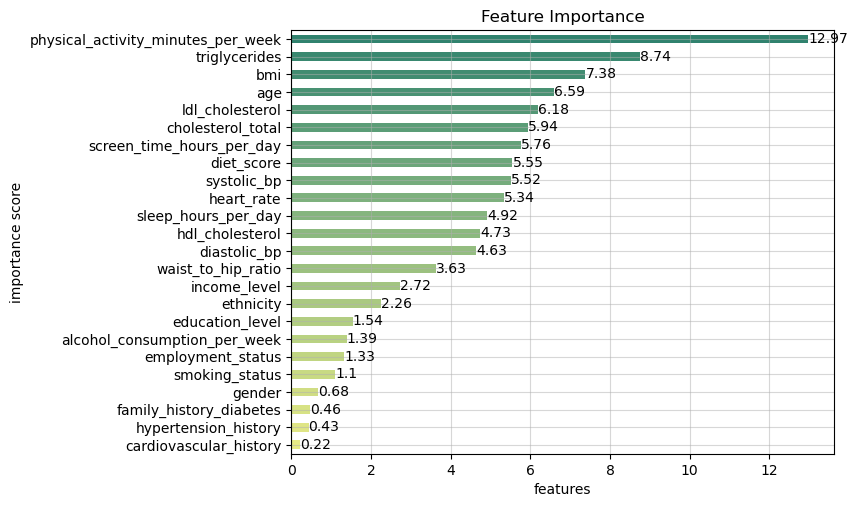

In [264]:
plot_importance(imp_t_2)

## LightGBM

In [242]:
def train_ensemble_3(X, y, cat_features, verbose=True):
    all_features = X.columns.to_list()
    importances = []
    
    oof_pred_proba = np.zeros(X.shape[0], dtype=float)
    oof_pred = np.zeros(X.shape[0], dtype=int)

    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    for n_fold, (train_id, valid_id) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_id].copy()
        y_train = y.iloc[train_id]
        
        X_valid = X.iloc[valid_id].copy()
        y_valid = y.iloc[valid_id]
        
        pr = Preprocessor()
        X_train = pr.fit_transform(X_train)
        X_valid = pr.transform(X_valid)
        
        model, y_pred_proba, y_pred  = train_lightgbm(params_lightgbm, [X_train, y_train], [X_valid, y_valid], 
                                                      cat_features=cat_features, num_boost_round=500)
        oof_pred_proba[valid_id] = y_pred_proba
        oof_pred[valid_id] = y_pred

        # importances
        imp_ser = pd.Series( dict( zip(all_features, model.feature_importance()) ), name=f'lgbm_importance_{n_fold}' )
        imp_ser = (imp_ser / np.sum(imp_ser)*100)
        importances.append(imp_ser)
        # verbose
        if verbose:
            acc_fold = accuracy_score(y_valid, y_pred)
            auc_fold = roc_auc_score(y_valid, y_pred_proba)
            print(f'LightGBM Model fold_{n_fold} | auc: {auc_fold:.4f} | accuracy: {acc_fold:.4f} ')

    acc = accuracy_score(y, oof_pred)
    auc = roc_auc_score(y, oof_pred_proba)
    
    print(f'LightGBM Model OOF | auc: {auc:.4f} | accuracy: {acc:.4f} ')
    # importances 
    imp_df = pd.DataFrame(importances).T
    imp_t = pd.Series(imp_df.mean(axis=1).round(2).sort_values(ascending=False).to_dict())
    
    return oof_pred_proba, imp_t

In [243]:
lgbm_oof, imp_t_3 = train_ensemble_3(train, target, base_cat_features)

LightGBM Model fold_0 | auc: 0.7276 | accuracy: 0.6852 
LightGBM Model fold_1 | auc: 0.7257 | accuracy: 0.6833 
LightGBM Model fold_2 | auc: 0.7278 | accuracy: 0.6844 
LightGBM Model fold_3 | auc: 0.7243 | accuracy: 0.6833 
LightGBM Model fold_4 | auc: 0.7245 | accuracy: 0.6841 
LightGBM Model fold_5 | auc: 0.7275 | accuracy: 0.6844 
LightGBM Model fold_6 | auc: 0.7262 | accuracy: 0.6842 
LightGBM Model fold_7 | auc: 0.7258 | accuracy: 0.6853 
LightGBM Model fold_8 | auc: 0.7260 | accuracy: 0.6837 
LightGBM Model fold_9 | auc: 0.7289 | accuracy: 0.6851 
LightGBM Model OOF | auc: 0.7264 | accuracy: 0.6843 


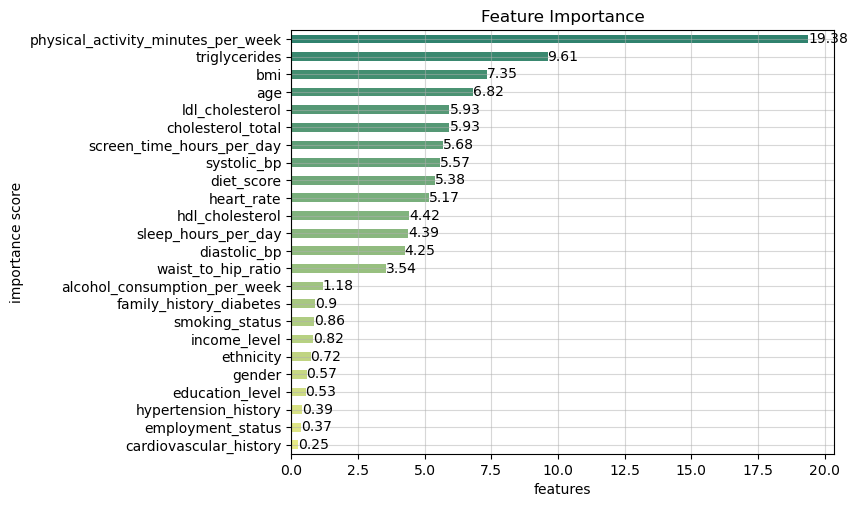

In [265]:
plot_importance(imp_t_3)

## Ensemble - MetaModel

In [248]:
OOF = pd.DataFrame()

OOF['CAT'] = cat_oof
OOF['XGB'] = xgb_oof
OOF['LGBM'] = lgbm_oof

In [257]:
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression(C = 0.1, max_iter = 1000)
meta_model.fit(OOF, target)

LogisticRegression(C=0.1, max_iter=1000)

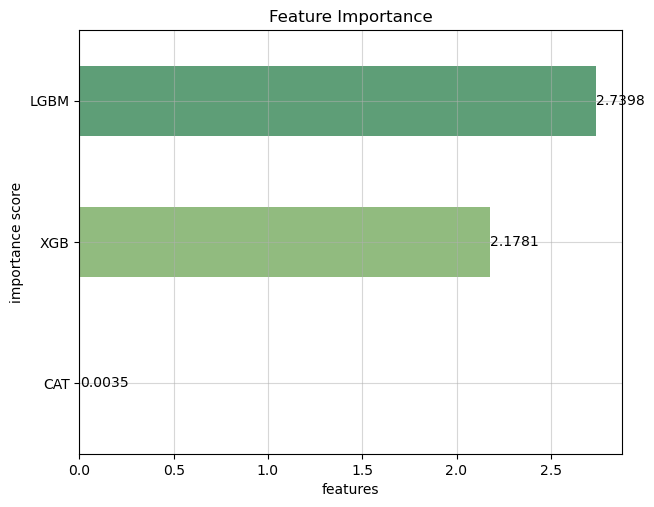

In [277]:
lr_imp = dict(zip(OOF.columns, meta_model.coef_.ravel()))
lr_imp = pd.Series(lr_imp).sort_values(ascending=False).round(4)
plot_importance(lr_imp)

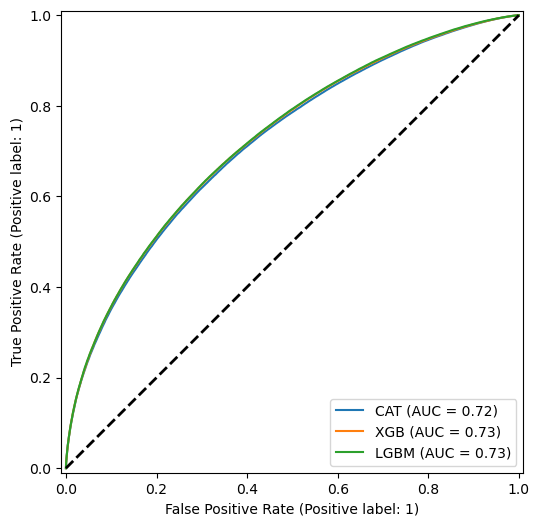

In [256]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
for col in OOF.columns:
    RocCurveDisplay.from_predictions(target, OOF[col], ax=ax, name=col)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
plt.show()

In [76]:
order = [['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High']]
enc = OrdinalEncoder(categories=order, 
                     dtype=int, 
                     handle_unknown="use_encoded_value",
                     unknown_value=-1,)

X_train['income_level'] = enc.fit_transform(X_train[['income_level']])
X_test['income_level'] = enc.transform(X_test[['income_level']])

In [77]:
cat_features = X_train.select_dtypes(include='object').columns.to_list()
num_features = X_train.select_dtypes(include='number').columns.to_list()

## submission

In [90]:
test_prep = test.copy()
test_prep['income_level'] = enc.transform(test[['income_level']])

y_preds_proba = model_0.predict_proba(test_prep)[:, 1]

In [92]:
def create_submission(y_preds, file_name):
    submission = pd.read_sql('SELECT * FROM sample_submission', config.engine)
    submission[config.target_name] = y_preds
    path = config.path_submissions+'/'+file_name+'.csv'
    
    submission.to_csv(path, index=False)

In [93]:
create_submission(y_preds_proba, 'naive_catboost')